In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load DataSet

df = pd.read_csv('https://raw.githubusercontent.com/UrielBender/BigData/master/DataSets/kyphosis.csv')
df.head()

Kyphosis  Age  Number  Start
0   absent   71       3      5
1   absent  158       3     14
2  present  128       4      5
3   absent    2       5      1
4   absent    1       4     15

In [4]:
df.info()
# 81 samples
# 3 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kyphosis  81 non-null     object
 1   Age       81 non-null     int64 
 2   Number    81 non-null     int64 
 3   Start     81 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.7+ KB


In [5]:
df.Kyphosis.replace({'absent':0,'present':1}, inplace=True)
df.head()

Kyphosis  Age  Number  Start
0         0   71       3      5
1         0  158       3     14
2         1  128       4      5
3         0    2       5      1
4         0    1       4     15

## EDA

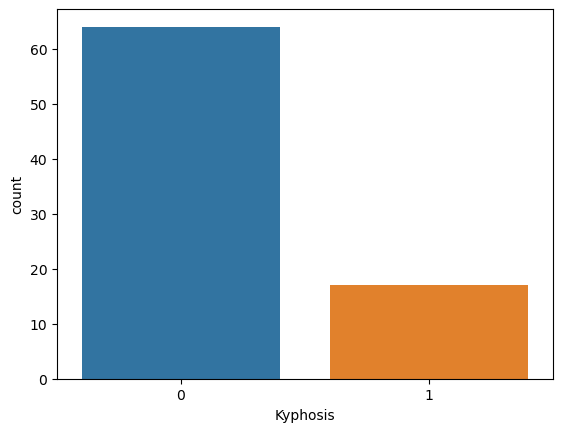

In [7]:
sns.countplot(x='Kyphosis',data=df)
# Count plot

### Missing values checking

In [8]:
df.isna().sum()

Kyphosis    0
Age         0
Number      0
Start       0
dtype: int64

### Decision Tree model

In [9]:
# No need to scale the data - relatively small range
X = df.drop('Kyphosis', axis=1)
y = df.Kyphosis
X

Age  Number  Start
0    71       3      5
1   158       3     14
2   128       4      5
3     2       5      1
4     1       4     15
..  ...     ...    ...
76  157       3     13
77   26       7     13
78  120       2     13
79   42       7      6
80   36       4     13

[81 rows x 3 columns]

In [10]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=1234)

In [11]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy',max_depth=7)

In [12]:
# train
dtree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [13]:
# Display the tree graphically
from sklearn import tree

In [16]:
df.iloc[5]

Kyphosis     0
Age          1
Number       2
Start       16
Name: 5, dtype: int64

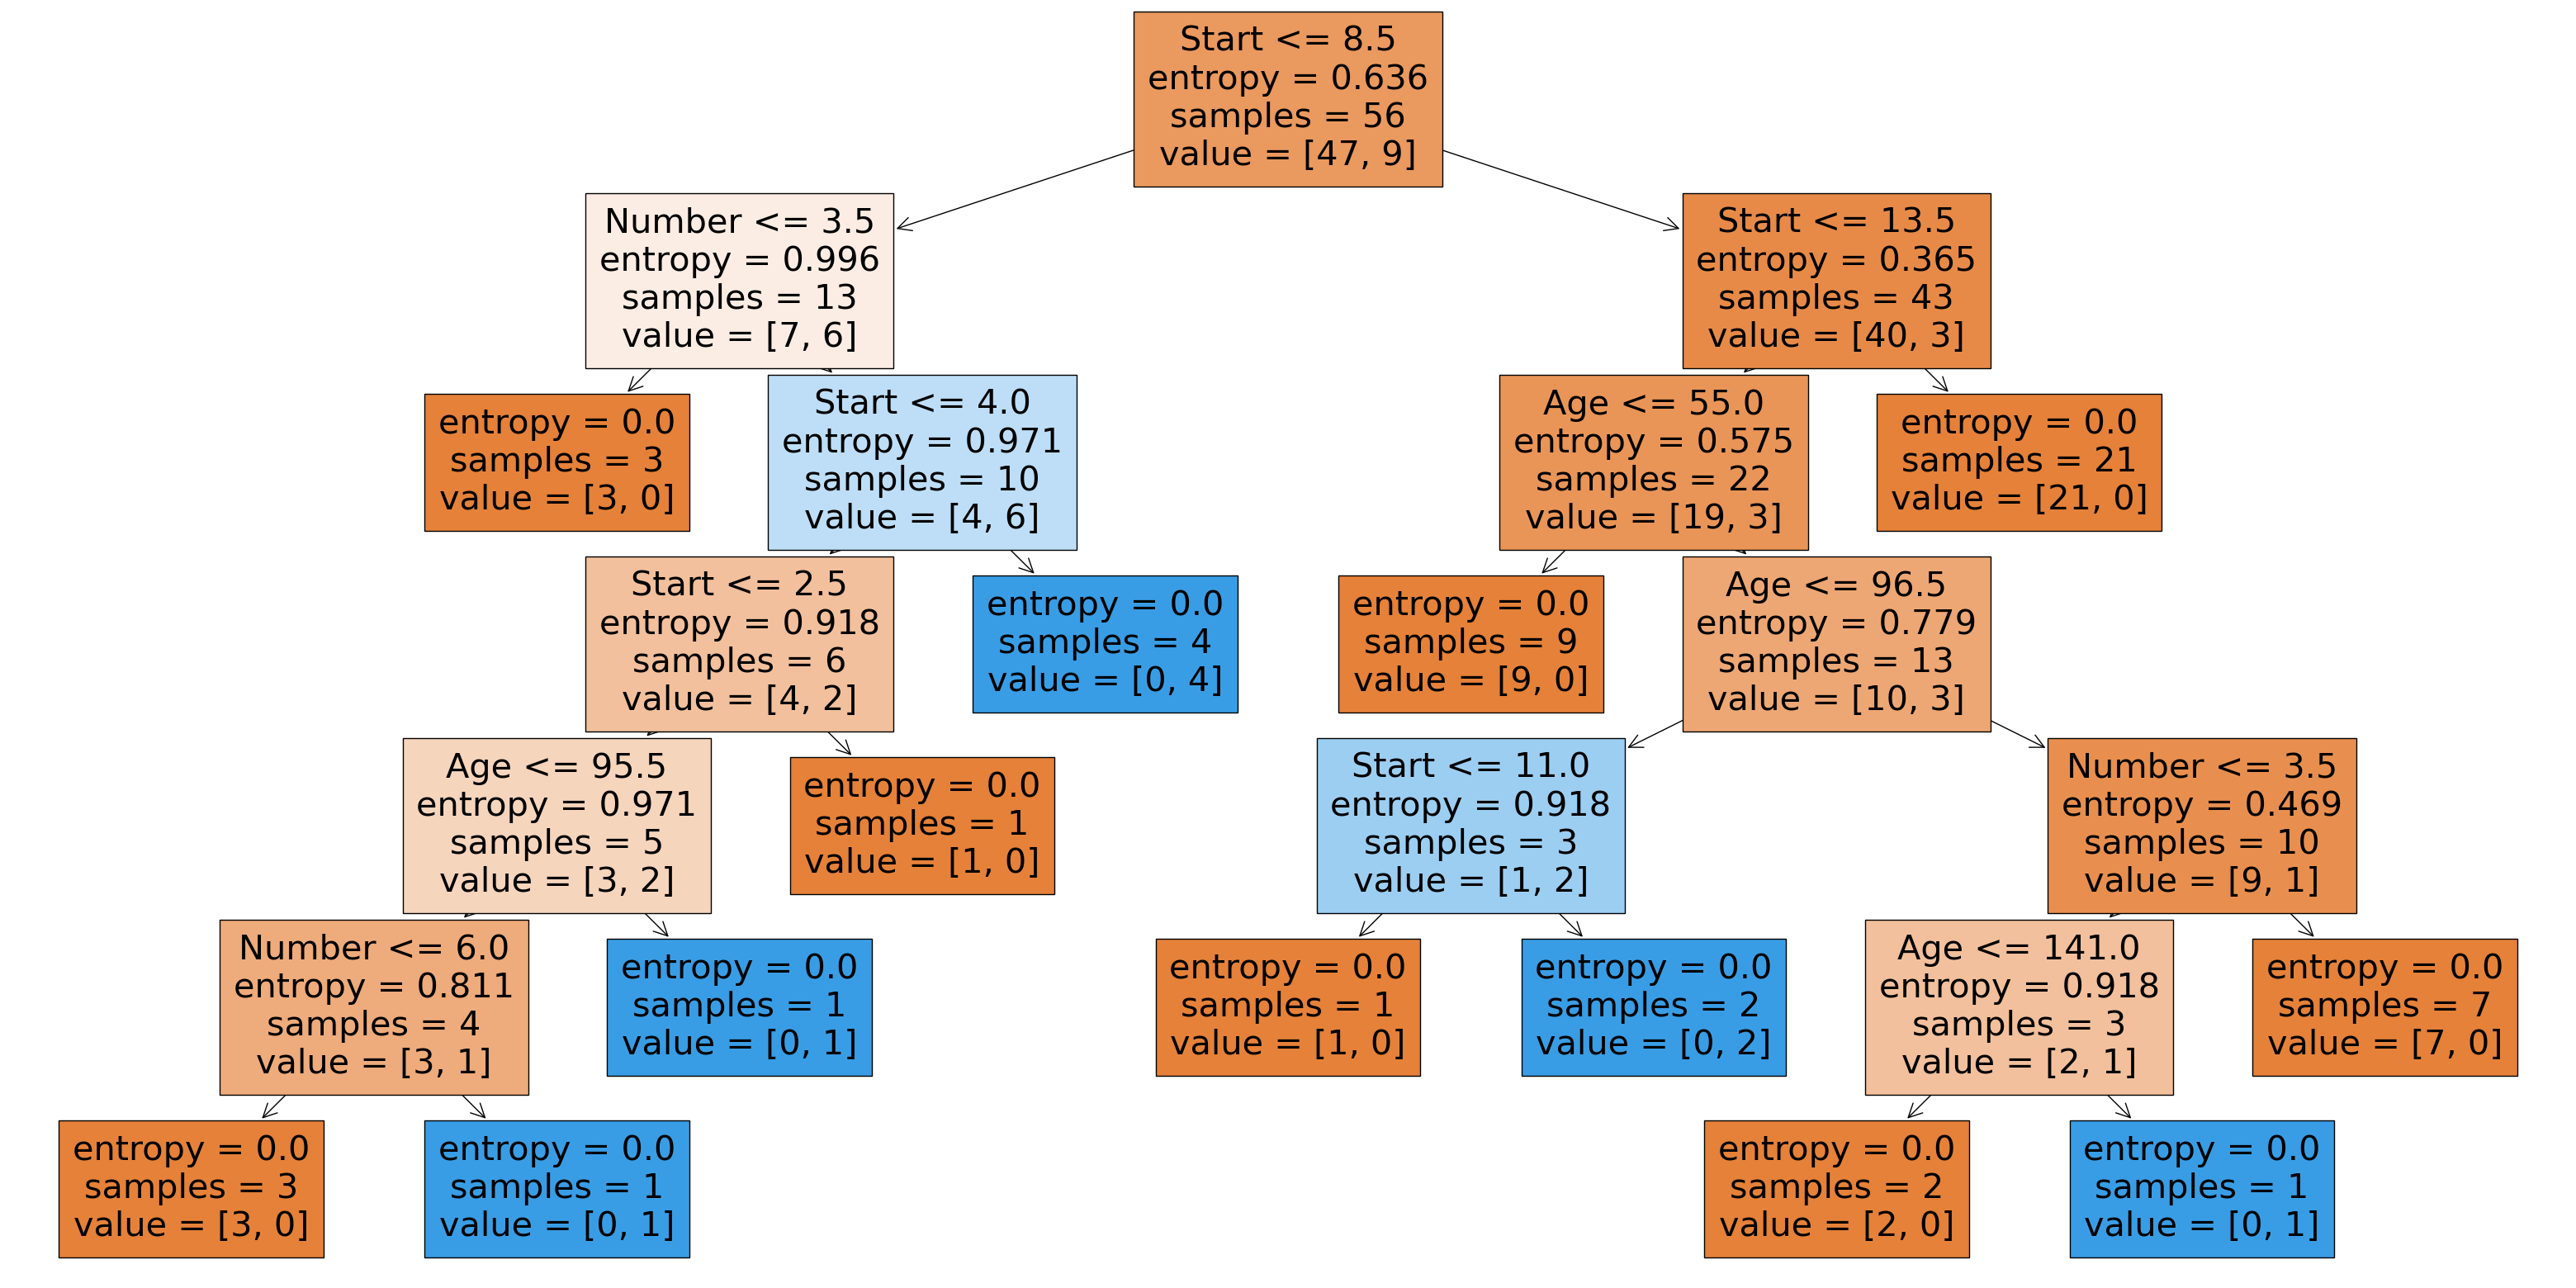

In [20]:
features = list(X.columns)

plt.figure(figsize=(40,20))
tree_img = tree.plot_tree(dtree, feature_names=features, filled=True)
plt.show()

# Left branch == True
# Right branch == False
# In leaves the entropy is 0

# Kyphosis == Blue Leaves
# No Kyphosis == Dark orange Leaves

## Feature Importance

In [22]:
print(dtree.feature_importances_)

[0.26845898 0.23626812 0.4952729 ]


In [25]:
fig = go.Figure()
trace = go.Bar(x=dtree.feature_importances_, y=features, orientation='h')
fig.add_trace(trace)

# 'Start' is the most important

## Prediction and Evaluation

In [26]:
y_pred = dtree.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
pred_df = pd.DataFrame({'Actual': df.Kyphosis, 'Prediction':y_pred}, index=y_test.index)
pred_df.head()

Actual  Prediction
74       0           0
40       1           0
10       1           0
57       1           1
29       0           0

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_df))
print(classification_report(y_test, y_pred_df))

# Better at predicting the '0' label (f1-score = 0.89). Has more samples in the train data that '1'
# Less good at predicting the '1' label (f1-score = 0.67)

[[17  0]
 [ 4  4]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           1       1.00      0.50      0.67         8

    accuracy                           0.84        25
   macro avg       0.90      0.75      0.78        25
weighted avg       0.87      0.84      0.82        25



# Random Forest

## Ensemble of trees
Rather than just relying on one Decision Tree and hoping we made the right decision at each split, Ensemble Methods allow us to take a sample of Decision Trees into account, calculate which features to use or questions to ask at each split, and make a final predictor based on the aggregated results of the sampled Decision Trees

In [30]:
# Creating a random forest model classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=30,criterion='entropy')

In [32]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=30)

In [34]:
# Testing the model
y_pred = rfc.predict(X_test)

In [35]:
# Evaluation
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[17  0]
 [ 7  1]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        17
           1       1.00      0.12      0.22         8

    accuracy                           0.72        25
   macro avg       0.85      0.56      0.53        25
weighted avg       0.80      0.72      0.64        25



### Random Forest: Cross Validation for evaluating

In [36]:
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rfc,X,y,cv=10,scoring='roc_auc')
auc_scores

array([0.78571429, 0.57142857, 1.        , 0.85714286, 0.625     ,
       0.91666667, 0.83333333, 0.91666667, 0.91666667, 0.83333333])

In [37]:
accuracy_scores = cross_val_score(rfc,X,y,cv=10,scoring='accuracy')
accuracy_scores

array([0.88888889, 0.875     , 0.875     , 0.875     , 0.625     ,
       0.875     , 0.625     , 0.625     , 0.75      , 0.875     ])

In [38]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy:',accuracy_scores.mean())

Mean values
auc: 0.8255952380952382
accuracy: 0.788888888888889
